# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from PIL import Image
import random

/home/hanseungsoo/project/naver_boostcamp/cv_project1/project1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Dataset Class

In [3]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        info_df: pd.DataFrame, 
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록
        self.images=[None]*len(info_df)
        
        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        if self.images[index] is None:
            img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 GRAY 포맷으로 변환합니다.
            
            self.images[index] = image
        else:
            image = self.images[index]
        
        if self.transform:
            image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.
        else:
            pass
                
        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다. 

# Transform Class

In [4]:
class UnsharpMask(A.ImageOnlyTransform):
    def __init__(self, kernel_size=5, sigma=1.0, amount=1.0, threshold=0, always_apply=False, p=1.0):
        super(UnsharpMask, self).__init__(always_apply, p)
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.amount = amount
        self.threshold = threshold

    def apply(self, image, **params):
        return self.unsharp_mask(image)

    def unsharp_mask(self, image):
        blurred = cv2.GaussianBlur(image, (self.kernel_size, self.kernel_size), self.sigma)
        sharpened = cv2.addWeighted(image, 1.0 + self.amount, blurred, -self.amount, 0)
        if self.threshold > 0:
            low_contrast_mask = np.absolute(image - blurred) < self.threshold
            np.copyto(sharpened, image, where=low_contrast_mask)
        return sharpened

In [5]:
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            transforms.Grayscale(num_output_channels=1),
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(common_transforms +
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정,
                ] 
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
        
        transformed = self.transform(image)  # 설정된 변환을 적용
        
        return transformed  # 변환된 이미지 반환

In [6]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.ToGray(p=1.0),  # 그레이스케일 변환
            UnsharpMask(kernel_size=7, sigma=1.5, amount=1.5, threshold=0, always_apply=False, p=1.0),  # 언샤프 마스크 적용
            A.Normalize(mean=[0.5], std=[0.5]),  # 그레이스케일 이미지에 맞는 정규화
            ToTensorV2(),  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [   A.HorizontalFlip(p=0.9), # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=30), # 최대 15도 회전
                    A.RandomBrightnessContrast(brightness_limit=(-0.2, -0.2), contrast_limit=0, p=0.9), # 10% 어둡게
                    #A.GaussianBlur(blur_limit=(3, 5), p=0.6), # 약간의 블러 추가
                    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
                    A.GridDistortion(always_apply=False, p=1, num_steps=1, distort_limit=(-0.03, 0.05), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None)
                    #A.ElasticTransform()
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")
        
        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용
        
        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [7]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type
        
        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):
        
        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)
        
        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)
        
        return transform

# Model Class

In [8]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)
        
        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        
        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [9]:
class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool,
        in_chans: int
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=num_classes,
            in_chans=in_chans
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [10]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self, 
        model_type: str, 
        num_classes: int, 
        **kwargs
    ):
        
        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)
        
        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)
        
        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

# Loss Class

In [11]:
class FocalLossWithLabelSmoothing(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, label_smoothing=0.1, reduction='mean'):
        super(FocalLossWithLabelSmoothing, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, logits, target):
        # Apply label smoothing
        num_classes = logits.size(-1)
        one_hot = torch.zeros_like(logits).scatter(1, target.unsqueeze(1), 1)
        smoothed_labels = (1 - self.label_smoothing) * one_hot + self.label_smoothing / num_classes

        # Compute log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        
        # Focal Loss component
        probs = torch.exp(log_probs)  # Convert log probs back to probs
        focal_weight = (1 - probs) ** self.gamma
        
        # Compute Focal Loss with label smoothing
        loss = -smoothed_labels * focal_weight * log_probs
        
        # Optionally apply reduction (mean or sum)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        
        return loss

In [12]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for multi-class classification.
    """
    def __init__(self, alpha, gamma, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # cross entropy loss
        ce_loss = F.cross_entropy(outputs, targets, reduction='none')
        
        # 각 클래스 softmax
        probs = torch.exp(-ce_loss)
        
        # focal loss 식
        focal_loss = self.alpha * (1 - probs) ** self.gamma * ce_loss
        
        # return mean OR sum
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [13]:
class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self,a=1,g=2):
        super(Loss, self).__init__()
        #self.loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.loss_fn = FocalLoss(a, g)
        #self.loss_fn = FocalLossWithLabelSmoothing(alpha=1.0, gamma=2.0, label_smoothing=0.1)

    def forward(
        self, 
        outputs: torch.Tensor, 
        targets: torch.Tensor
    ) -> torch.Tensor:
    
        return self.loss_fn(outputs, targets)

# Model Training

In [14]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda')

In [16]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "../data/train"
traindata_info_file = "../data/train.csv"
save_result_path = "../train_result"

# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.

testdata_dir = "../data/test"
testdata_info_file = "../data/test.csv"
test_info = pd.read_csv(testdata_info_file)

In [17]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, min_lr=0):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        else:
            # Cosine annealing after warmup
            progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return max(cosine_decay, min_lr / optimizer.defaults['lr'])

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): 성능이 향상되지 않더라도 몇 에폭 동안 기다릴지 설정.
            min_delta (float): 성능 향상 최소 한계. 이보다 작은 변화는 무시.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # 성능이 향상되면 카운터를 초기화
        else:
            self.counter += 1  # 향상이 없으면 카운터 증가
            if self.counter >= self.patience:
                self.early_stop = True


In [18]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset


n_splits=5
batch_size=64
loss_fn = Loss(a=0.5,g=2)
num_epochs=30
num_classes=500

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 학습에 사용할 Transform을 선언.
early_stopping = EarlyStopping(patience=5, min_delta=0.001)


for fold, (train_idx, val_idx) in enumerate(skf.split(train_info, train_info['target'])):

    # 학습에 사용할 Model을 선언.
    model_selector = ModelSelector(
                model_type='timm', 
                num_classes=num_classes,
                model_name='efficientnetv2_rw_t.ra2_in1k', 
                pretrained=True,
                in_chans=3
                )
        
    model = model_selector.get_model().to(device)
    
    optimizers=[
        optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8),
    ]

    optimizer = optimizers[0]

    transform_selector = TransformSelector(
        transform_type = "albumentations"
    )

    train_transform = transform_selector.get_transform(is_train=True)
    val_transform = transform_selector.get_transform(is_train=False)
    

        # train_df와 val_df를 train_idx와 val_idx로 분할
    train_df = train_info.iloc[train_idx]
    val_df = train_info.iloc[val_idx]

    # 학습에 사용할 Dataset을 선언.
    train_dataset = CustomDataset(
        root_dir=traindata_dir,
        info_df=train_df,
        transform=train_transform,
        #augmentation=augmented_transform,
        #is_train=True
    )

    # 학습에 사용할 Dataset을 선언.
    valid_dataset = CustomDataset(
        root_dir=traindata_dir,
        info_df=val_df,
        transform=val_transform,
        #augmentation=augmented_transform,
        #is_train=True
    )
    
    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)


        # 스케줄러 초기화
    scheduler_step_size = 30  # 매 30step마다 학습률 감소
    scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

    # 한 epoch당 step 수 계산
    steps_per_epoch = len(train_loader)

    # 2 epoch마다 학습률을 감소시키는 스케줄러 선언
    epochs_per_lr_decay = 3
    scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

    # Warmup settings
    warmup_steps = 2 * len(train_loader)  # Number of steps for warmup
    total_steps = 30 * len(train_loader)  # Total training steps

    schedulers = [
                get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, min_lr=1e-5),
    ]

    scheduler = schedulers[0]
    
    
    for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            model.train()
            running_loss, correct = 0.0,0
            progress_bar = tqdm(train_loader, desc="Training", leave=False)
            for images, targets in progress_bar:
                images, targets = images.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                scheduler.step()
                running_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                correct += torch.sum(outputs.argmax(1) == targets).item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, accuracy: {(100*correct/len(train_loader.dataset))}')

            # 검증
            model.eval()
            val_loss,correct = 0.0,0
            correct = 0
            total = 0
            progress_bar = tqdm(val_loader, desc="Validating", leave=False)

            with torch.no_grad():
                for images, labels in progress_bar:
                    images, labels = images.to(device),labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    progress_bar.set_postfix(loss=loss.item())
                    correct += torch.sum(outputs.argmax(1) == labels).item()
                early_stopping(val_loss)
            
            print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {(100*correct/len(val_loader.dataset)):.2f}%')

            # 가장 낮은 validation loss 모델 저장
            if epoch > 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()  # 모델의 상태 저장
                    best_model_path = os.path.join(save_result_path, './best_model_{}.pt'.format(fold))
                    torch.save(best_model_state, best_model_path)
                    print(f"Best model saved with validation loss: {best_val_loss/len(val_loader):.4f}")
                else:
                    pass
            else: 
                best_val_loss = val_loss

    # 가장 낮은 validation loss를 기록한 모델 불러오기
    best_model = model_selector.get_model()
    best_models = []
    best_models.append(best_model.load_state_dict(torch.load(best_model_path)))

# Inference

In [20]:
os.listdir(save_result_path)

['best_model_3.pt',
 'best_model_2.pt',
 'best_model_1.pt',
 'best_model_0.pt',
 'best_model_4.pt']

In [21]:
save_result_path='./train_result'
predicts = torch.zeros((len(test_info),500))
test_transform = transform_selector.get_transform(is_train=False)

test_dataset = CustomDataset(
        root_dir=testdata_dir,
        info_df=test_info,
        transform=test_transform,
        is_inference=True,
    )
    
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=False,num_workers=2)
best_model = model_selector.get_model()
for fold,_model in enumerate(os.listdir(save_result_path)):
    best_model.load_state_dict(torch.load(save_result_path+'/'+_model))
    best_model.eval()  # inference 모드로 설정

    correct = 0
    total = 0
    torch.cuda.empty_cache()
    progress_bar = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for i,images in enumerate(progress_bar):
            images= images.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)
            predicts[i * batch_size:(i + 1) * batch_size] += probs.cpu().numpy()  # 확률값 더하기

    print('{}_test_finish'.format(fold))

final_preds = np.argmax(predicts,axis=1)

/tmp/ipykernel_490767/833349002.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(save_result_path+'/'+_model))


0_test_finish


1_test_finish


2_test_finish


3_test_finish


4_test_finish


In [22]:
len(final_preds)

10014

In [23]:
test_info = pd.read_csv(testdata_info_file)
test_info

,image_path
0,0.JPEG
1,1.JPEG
2,2.JPEG
3,3.JPEG
4,4.JPEG
...,...
10009,10009.JPEG
10010,10010.JPEG
10011,10011.JPEG
10012,10012.JPEG


In [24]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info = pd.read_csv(testdata_info_file)
test_info['target'] = final_preds
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,493
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,111
10011,10011,10011.JPEG,219
10012,10012,10012.JPEG,351


In [26]:
# DataFrame 저장
test_info.to_csv("../submissions/ss_output_0925_1_efficientv2_everything.csv", index=False)

## Ensemble

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [111]:
model_names = ['caformer','coatnet','effv2','eva14','nfnet_final','resnet101_888']

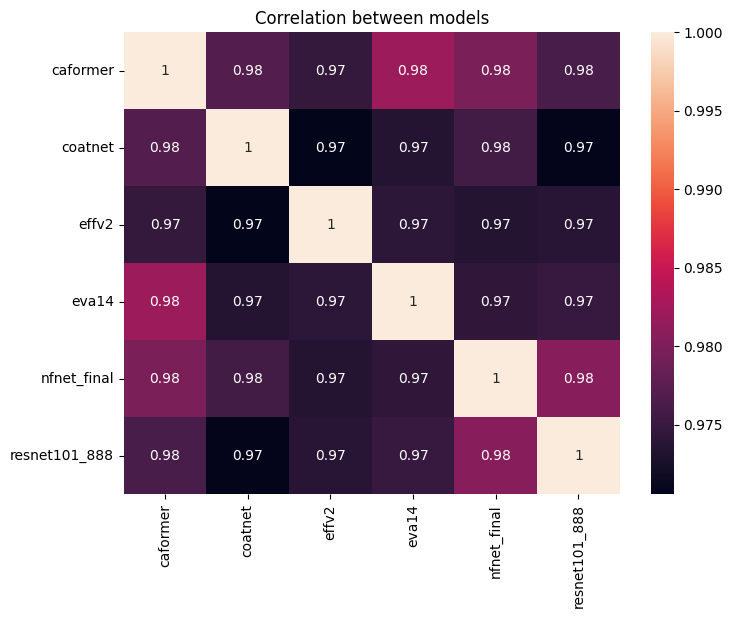

In [112]:
sub_list = pd.DataFrame({'target':[0]*10014})

for s in model_names:
    sub = pd.read_csv('../submissions/final_results/output_'+s+'.csv')
    sub_list[s] = sub['target']

plt.figure(figsize = (8,6))
g = sns.heatmap(sub_list.iloc[:,1:].corr(),annot=True)
g.set_title("Correlation between models")
plt.show()


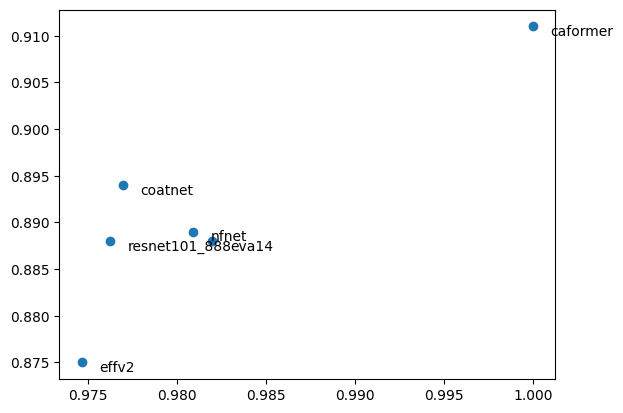

In [76]:
test_accuracy = {model_names[0]:0.9110,
                 model_names[1]:0.8940,
                 model_names[2]:0.8750,
                 model_names[3]:0.8880,
                 model_names[4]:0.8890,
                 model_names[5]:0.8880
                 }

scatters = pd.DataFrame({'correlation':sub_list.iloc[:,1:].corr().iloc[0],'accuracy':test_accuracy.values(),'name':test_accuracy.keys()})
plt.scatter(scatters['correlation'],scatters['accuracy'],)

for i in range(len(scatters)): # 행 개수만큼 순회
    row = scatters.iloc[i] # 한 행씩 꺼내기
    name = row['name'] # 이름이 저장된 열
    x = row['correlation'] # x좌표가 저장된 열
    y = row['accuracy'] # y좌표가 저장된 열

    plt.text(x+0.001, y-0.001, name) # x 좌표, y좌표, 이름 순서로 input 지정

plt.show()

In [ ]:
sub_list2 = sub_list.copy()

In [113]:
sub_list.drop(['effv2'],axis=1).iloc[:,1:]

,caformer,coatnet,eva14,nfnet_final,resnet101_888
0,328,328,328,328,328
1,414,414,414,414,414
2,493,493,493,493,493
3,17,17,17,17,17
4,388,388,388,388,388
...,...,...,...,...,...
10009,235,235,235,235,235
10010,191,191,191,86,86
10011,466,466,466,466,466
10012,400,351,258,400,400


In [114]:
#sub_list

final_prediction = sub_list.drop(['effv2'],axis=1).iloc[:,1:].mode(axis=1).iloc[:,0].astype(int)
final_prediction

0        328
1        414
2        493
3         17
4        388
        ... 
10009    235
10010    191
10011    466
10012    400
10013    210
Name: 0, Length: 10014, dtype: int64

In [115]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info = pd.read_csv(testdata_info_file)
test_info['target'] = final_prediction
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,493
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,191
10011,10011,10011.JPEG,466
10012,10012,10012.JPEG,400


In [116]:
# DataFrame 저장
test_info.to_csv("../submissions/god_please.csv", index=False)

In [117]:
pd.read_csv('../submissions/god_please.csv')

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,493
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,191
10011,10011,10011.JPEG,466
10012,10012,10012.JPEG,400
